In [8]:
"""
Test the effect of subsampling in PH.
"""
from ripser import ripser
import anndata as ad
from matplotlib import pyplot as plt
import seaborn as sns
from topo import viz
import numpy as np
from persim import bottleneck
from sklearn.decomposition import PCA
from tqdm import tqdm
import pandas as pd
from topo.utils import greedy_farthest_point_sampling
from totopos import cells as tpc
from totopos.utils import jaccard_score
viz.set_plotting_style_plt()
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from os.path import join
cat = np.concatenate
fig_dir = "/home/mnu/projects/topo/figs/paper_figs/SI_figs/"

In [9]:
# Load data
a = ad.read_h5ad("/home/mnu/projects/topo/data/worm/worm_cv.h5ad")
pcs = a.obsm["pca"][:, :20]

In [10]:
# Sampling fractions
fracs = np.array([0.25, 0.1, 0.05, 0.01], dtype=float)

In [11]:
# Initialize dictionary to store results
sim_dict = {}

In [12]:
# Compute persistent homology and sampling indices
for frac in tqdm(fracs, desc="Computing PH"):
    ixs, hausd = greedy_farthest_point_sampling(pcs, n_points=int(a.n_obs * frac))
    ph = ripser(pcs[ixs], maxdim=1, coeff=2, do_cocycles=True)
    sim_dict[f"{frac:.2f}".replace(".", "_")] = {
        "sample_ixs": ixs,
        "hausdorff_distance": hausd,
        "ph_dict": ph,
    }

Computing PH: 100%|██████████████████████████████████████████████████| 4/4 [25:23<00:00, 380.89s/it]


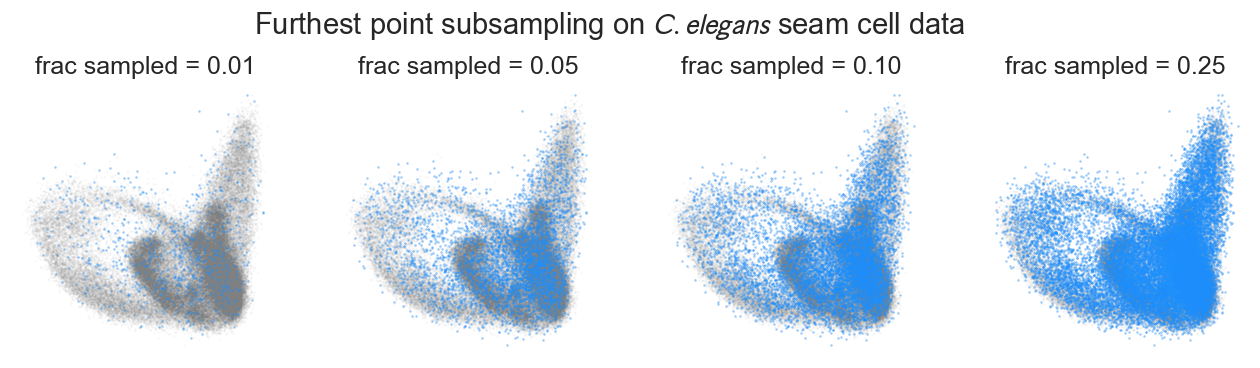

In [13]:
# Visualize subsampling
fig, axes = plt.subplots(1, len(fracs), figsize=(len(fracs) * 4, 4))
for i, frac in enumerate(fracs[::-1]):
    key = f"{frac:.2f}".replace(".", "_")
    ax = axes[i]
    ax.scatter(*pcs[:, (1, 2)].T, color="grey", s=0.5, alpha=0.05)
    ax.scatter(*pcs[sim_dict[key]["sample_ixs"]][:, (1, 2)].T, color="dodgerblue", s=1, marker="*", alpha=0.3)
    ax.set_title(f"frac sampled = {frac:.2f}", fontsize=18)
    ax.axis("off")
plt.suptitle("Furthest point subsampling on $C. elegans$ seam cell data", fontsize=21)
plt.subplots_adjust(top=0.8)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


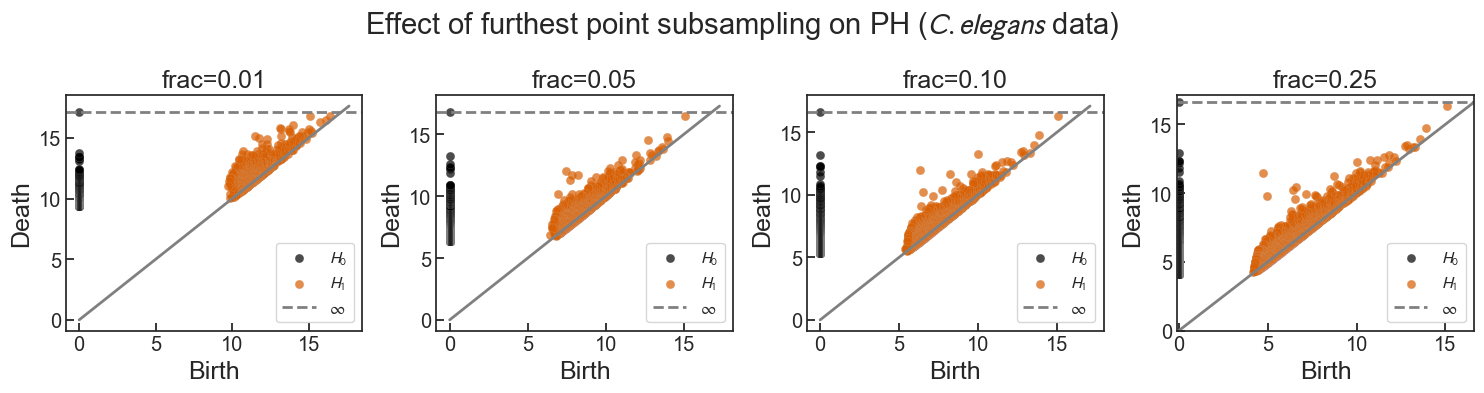

In [14]:
# Visualize persistence diagrams
fig, axes = plt.subplots(1, len(fracs), figsize=(15, 4))
for i, frac in enumerate(fracs[::-1]):
    key = f"{frac:.2f}".replace(".", "_")
    ax = axes[i]
    dgms = sim_dict[key]["ph_dict"]["dgms"]
    viz.plot_pers_diag_ripser(dgms, ax=ax)
    ax.set_title(f"frac={frac:.2f}", fontsize=18)
    ax.set_xlabel("Birth")
    ax.set_ylabel("Death")
    ax.legend()
plt.suptitle("Effect of furthest point subsampling on PH ($C. elegans$ data)", fontsize=21)
plt.subplots_adjust(top=0.8)
plt.tight_layout()
plt.show()

In [15]:
# Compute topological loop
for key in sim_dict.keys():
    sim_dict[key]["topo_data"] = tpc.critical_edge_method(
        data=pcs[sim_dict[key]["sample_ixs"]],
        ph=sim_dict[key]["ph_dict"],
        n_loops=2,
    )

100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/it]


Compute topocells

In [16]:
# Compute topocells for each key and loop
for key in sim_dict.keys():
    for loop_idx in [0, 1]:
        zero_sk_ids = sim_dict[key]["sample_ixs"][np.unique(sim_dict[key]["topo_data"][loop_idx]["loop"])]
        topoCells, topocell_ixs = tpc.get_loop_neighbors(
            pcs, pcs[zero_sk_ids], sim_dict[key]["topo_data"][loop_idx]["birth_dist"]
        )
        sim_dict[key]["topo_data"][loop_idx].update({"topocells": topoCells, "topocell_ixs": topocell_ixs})

In [65]:
a[sim_dict["0_25"]["topo_data"][0]["topocell_ixs"]].obs.cell_type.value_counts(True).head()

cell_type
Hypodermis         0.698602
Seam_cell          0.286162
T                  0.013150
G2_and_W_blasts    0.002087
Name: proportion, dtype: float64

In [369]:
a[sim_dict["0_25"]["topo_data"][1]["topocell_ixs"]].obs.cell_type.value_counts(True).head()

cell_type
Hypodermis                    0.699219
Ciliated_amphid_neuron        0.058594
Seam_cell                     0.058594
Ciliated_non_amphid_neuron    0.049479
Pharyngeal_neuron             0.022693
Name: proportion, dtype: float64

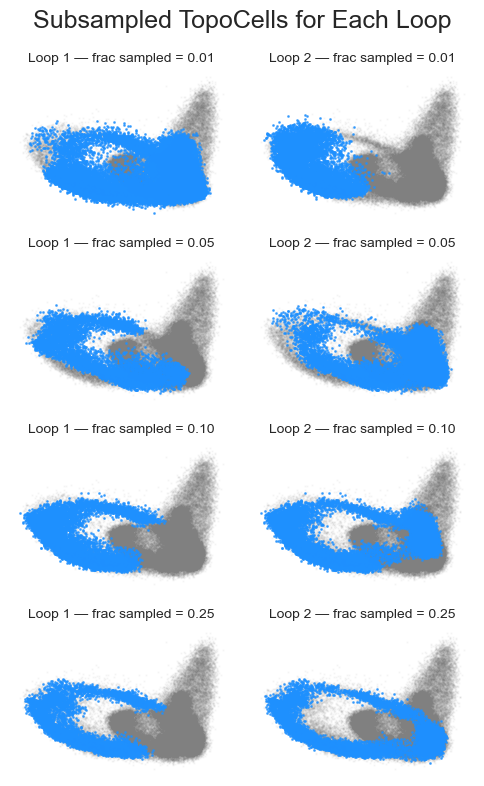

In [377]:
# Visualize subsampled topoCells for each loop
fig, axes = plt.subplots(len(fracs), 2, figsize=(5, len(fracs) * 2))

for i, frac in enumerate(fracs[::-1]):
    key = f"{frac:.2f}".replace(".", "_")
    for loop_idx in [0, 1]:
        ax = axes[i, loop_idx]
        topoCells = sim_dict[key]["topo_data"][loop_idx]["topocells"]
        ax.scatter(*pcs[:, (1, 2)].T, color="grey", s=0.5, alpha=0.05)
        ax.scatter(*topoCells[:, (1, 2)].T, color="dodgerblue", s=1, marker="o", alpha=0.7)
        ax.set_title(f"Loop {loop_idx + 1} — frac sampled = {frac:.2f}", fontsize=10)
        ax.axis("off")

plt.suptitle("Subsampled TopoCells for Each Loop", fontsize=18)
plt.tight_layout()
plt.show()

### Statistical analysis

In [17]:
# Compute Jaccard scores and compare to null distribution
results = {"loop_one": {}, "loop_two": {}}

In [19]:
reference_key = f"{fracs[0]:.2f}".replace(".", "_")

In [20]:
for key in list(sim_dict.keys())[1:]:
    query_key = key

    # Compute Jaccard scores for the test data
    score_loop_one = jaccard_score(
        sim_dict[reference_key]["topo_data"][0]["topocell_ixs"],
        sim_dict[query_key]["topo_data"][0]["topocell_ixs"],
    )
    score_loop_two = jaccard_score(
        sim_dict[reference_key]["topo_data"][1]["topocell_ixs"],
        sim_dict[query_key]["topo_data"][1]["topocell_ixs"],
    )

    # Compute null distributions
    n_sims = 1000
    random_scores_loop_one = []
    random_scores_loop_two = []

    for _ in tqdm(range(n_sims)):
        # Random subset for loop 1
        random_subset_one = np.random.choice(
            pcs.shape[0], size=len(sim_dict[query_key]["topo_data"][0]["topocell_ixs"]), replace=False
        )
        random_score_one = jaccard_score(
            sim_dict[reference_key]["topo_data"][0]["topocell_ixs"], random_subset_one
        )
        random_scores_loop_one.append(random_score_one)

        # Random subset for loop 2
        random_subset_two = np.random.choice(
            pcs.shape[0], size=len(sim_dict[query_key]["topo_data"][1]["topocell_ixs"]), replace=False
        )
        random_score_two = jaccard_score(
            sim_dict[reference_key]["topo_data"][1]["topocell_ixs"], random_subset_two
        )
        random_scores_loop_two.append(random_score_two)

    # Convert to numpy arrays for easier analysis
    random_scores_loop_one = np.array(random_scores_loop_one)
    random_scores_loop_two = np.array(random_scores_loop_two)

    # Compute z-scores
    z_score_loop_one = (score_loop_one - random_scores_loop_one.mean()) / random_scores_loop_one.std()
    z_score_loop_two = (score_loop_two - random_scores_loop_two.mean()) / random_scores_loop_two.std()

    # Store results
    results["loop_one"][query_key] = {
        "score": score_loop_one,
        "z_score": z_score_loop_one,
        "null_distribution": random_scores_loop_one,
    }
    results["loop_two"][query_key] = {
        "score": score_loop_two,
        "z_score": z_score_loop_two,
        "null_distribution": random_scores_loop_two,
    }

In [ ]:
# Number of fractions
n = len(results["loop_one"])

# --- Figure for Loop 1 ---
fig1, axes1 = plt.subplots(nrows=n, ncols=1, figsize=(6, 4*n), sharex=False, sharey=False)

for i, (key, data) in enumerate(results["loop_one"].items()):
    ax = axes1[i]
    # histogram
    sns.distplot(data["null_distribution"],label="null ditribution", ax = ax)
    # test score line
    ax.axvline(
        data["score"],
        color="grey",
        linestyle="--",
        label="Test score"
    )
    # title & labels
    frac = f"{key.split('_')[0]}.{key.split('_')[1]}"
    ax.set_title(f"Loop 1 — frac={frac}")
    ax.set_xlabel("Jaccard Score")
    ax.set_ylabel("Frequency")
    # vertical grid lines
    ax.grid(axis='x', linestyle='--', alpha=0.5)
    ax.legend()

fig1.tight_layout()
fig1.suptitle("Loop 1: Jaccard Score vs. Null Distribution", fontsize=14, y=1.02)


# --- Figure for Loop 2 ---
fig2, axes2 = plt.subplots(nrows=n, ncols=1, figsize=(6, 4*n), sharex=False, sharey=False)

for i, key in enumerate(results["loop_one"].keys()):
    data2 = results["loop_two"][key]
    ax = axes2[i]
    sns.distplot(data2["null_distribution"],label="null ditribution", ax = ax)

    ax.axvline(
        data2["score"],
        color="grey",
        linestyle="--",
        label="Test score"
    )
    frac = f"{key.split('_')[0]}.{key.split('_')[1]}"
    ax.set_title(f"Loop 2 — frac={frac}")
    ax.set_xlabel("Jaccard Score")
    ax.set_ylabel("Frequency")
    ax.grid(axis='x', linestyle='--', alpha=0.5)
    ax.legend()

fig2.tight_layout()
fig2.suptitle("Loop 2: Jaccard Score vs. Null Distribution", fontsize=14, y=1.02)

plt.show()

/tmp/ipykernel_733526/4168938508.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_733526/4168938508.py:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


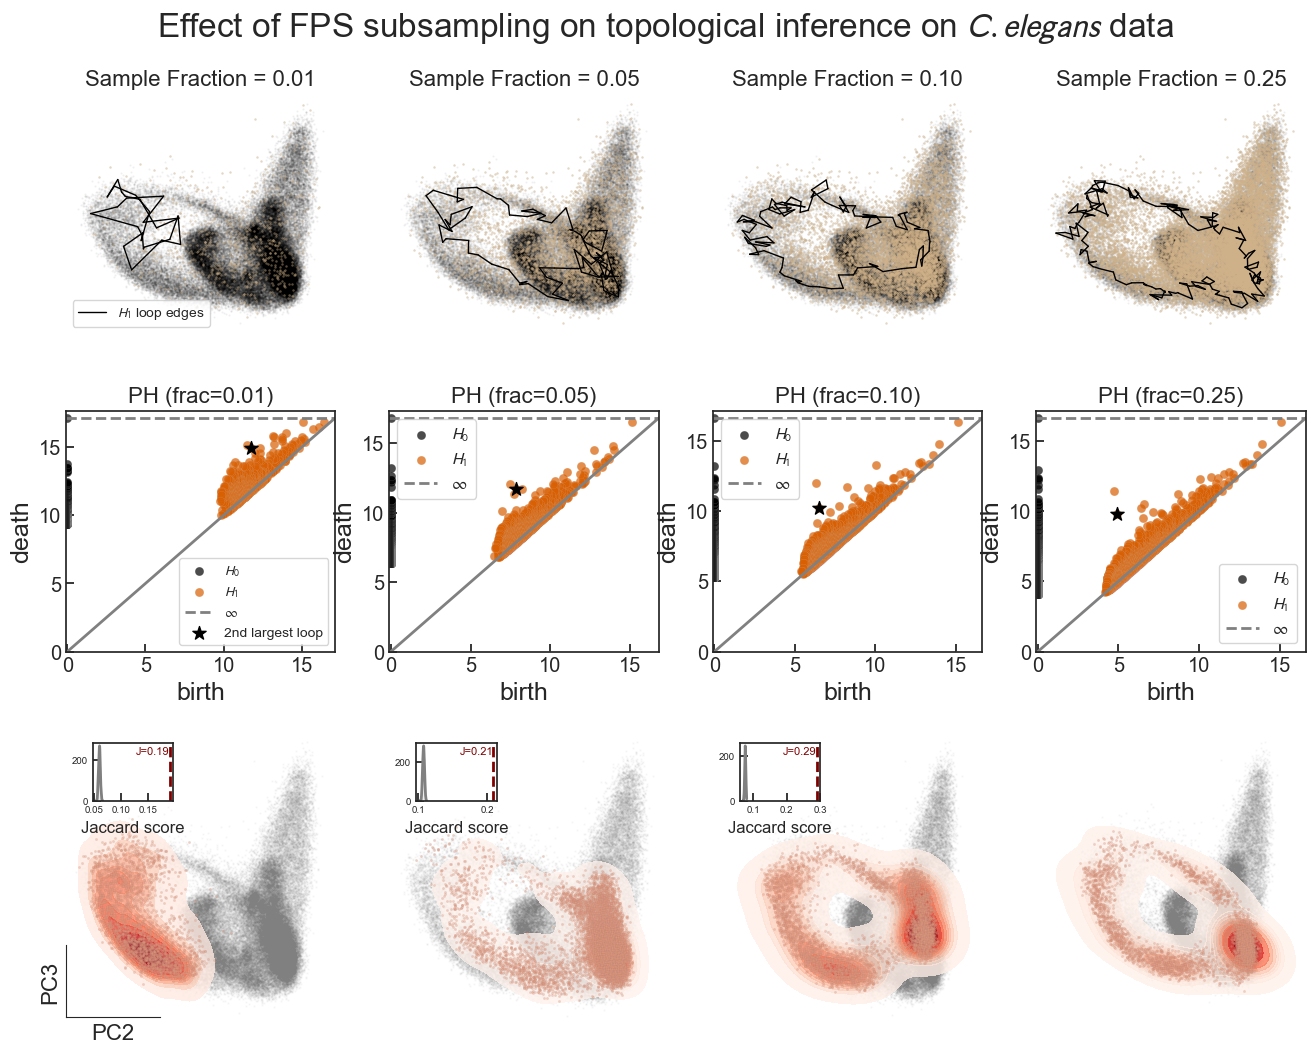

In [370]:

# Initialize composite figure
fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(3, len(fracs), height_ratios=[1, 1, 1.2], hspace=0.3, wspace=0.2)

# Color palette
bg_color = "#f7f7f7"
point_color = "black"
sample_color = "tan"
topo_color = "darksalmon"

dims= (1,2)
d=2

loop_idx = 1  # You can parameterize or loop through loops here

# 1. Visualize subsampling with FPS
for i, frac in enumerate(fracs[::-1]):
    ax = fig.add_subplot(gs[0, i])
    key = f"{frac:.2f}".replace(".", "_")
    ax.scatter(*pcs[:, dims].T, color=point_color, s=0.3, alpha=0.05)
    
    data = pcs[sim_dict[key]["sample_ixs"]][:,dims]

    ax.scatter(*data.T, color=sample_color, s=1, marker= "*", alpha=0.3, label = "FPS subsample")
    
    for e in sim_dict[key]["topo_data"][loop_idx]["loop"]:
        source,tgt=e
        data_plot=cat([data[np.array([source]), :d], data[np.array([tgt]), :d]], 0)
        ax.plot(*data_plot.T, color = "black", linewidth=1, label="H1 Homology Loop" if source == sim_dict[key]["topo_data"][loop_idx]["loop"][0][0] else "")
    
    ax.set_title(f"Sample Fraction = {frac:.2f}", fontsize=16)
    ax.set_facecolor(bg_color)
    ax.axis("off")

# Adding Loop legend to first subplot
loop_line = mlines.Line2D([], [], color='black', linewidth=1, label=r'$H_1$ loop edges')
fig.axes[0].legend(handles=[loop_line], fontsize=10, loc='lower left')
#fig.axes[0].legend(fontsize=10, loc='upper right', frameon=False)


fig.suptitle("Effect of FPS subsampling on topological inference on $C. elegans$ data", fontsize=24,y=0.95)

# 2. Persistence diagrams
for i, frac in enumerate(fracs[::-1]):
    ax = fig.add_subplot(gs[1, i])
    key = f"{frac:.2f}".replace(".", "_")
    dgms = sim_dict[key]["ph_dict"]["dgms"]
    one_dgm = dgms[1]
    isort = np.argsort(one_dgm[:,1]-one_dgm[:,0])[::-1]
    x, y = one_dgm[isort[loop_idx]]

    viz.plot_pers_diag_ripser(dgms, ax=ax)
    ax.scatter(x, y, marker="*", color="black", s=100, label="2nd largest loop")
    ax.set_title(f"PH (frac={frac:.2f})", fontsize=16)
    ax.grid(True, linestyle='--', alpha=0.5)

    # Add legend only to first persistence plot
    if i == 0:
        ax.legend(fontsize=10, loc='lower right')


plt.tight_layout()
# 3. Visualize subsampled topoCells for each loop with KDE overlay

for i, frac in enumerate(fracs[::-1]):
    ax = fig.add_subplot(gs[2, i])
    key = f"{frac:.2f}".replace(".", "_")
    topoCells = sim_dict[key]["topo_data"][loop_idx]["topocells"]
    ax.scatter(*pcs[:, dims].T, color="grey", s=0.5, alpha=0.05)
    
    sns.kdeplot(x=topoCells[::5, dims[0]], y=topoCells[::5, dims[1]], ax=ax, cmap="Reds", fill=True, alpha=0.8, thresh=0.01)
    
    topo_df = pd.DataFrame(topoCells[::3,dims])
    sns.scatterplot(data = topo_df, x=0, y=1, s=3, alpha=0.4, edgecolor='grey',linewidth=.1, color = topo_color)
    #ax.set_title(f"topoCells for Loop {loop_idx + 1}\n(frac={frac:.2f})")#, fontsize=16)
    #ax.set_facecolor(bg_color)
    ax.axis("off")

    if i == 0:
        inset_pc_ax = ax.inset_axes([0.00, 0.00, 0.35, 0.25])
        #inset_pc_ax.scatter(*pcs[:, (1, 2)].T, color="black", s=0.1, alpha=0.01)
        inset_pc_ax.set_xlabel("PC2", fontsize=16)
        inset_pc_ax.set_ylabel("PC3", fontsize=16)
        inset_pc_ax.set_xticks([])
        inset_pc_ax.set_yticks([])
        # Hide top and right spines for cleaner look
        inset_pc_ax.spines['top'].set_visible(False)
        inset_pc_ax.spines['right'].set_visible(False)
    
        # Optionally, emphasize bottom/left spines
        inset_pc_ax.spines['left'].set_linewidth(0.8)
        inset_pc_ax.spines['bottom'].set_linewidth(0.8)
        inset_pc_ax.set_facecolor('none')

        #inset_pc_ax.set_title("Axes: PC1 vs PC3", fontsize=8)

    if frac==0.25:        
        continue

    # Inset Jaccard distribution
    inset_ax = ax.inset_axes([0.1, 0.75, 0.3, 0.2])
    sns.histplot(results["loop_two"][key]["null_distribution"], bins=10, kde=True,
                 ax=inset_ax, color='grey', alpha=0.85)
    inset_ax.axvline(results["loop_two"][key]["score"], color='maroon', linestyle='--', label="Observed")
    inset_ax.set_xlabel('Jaccard score', fontsize=12)
    inset_ax.set_ylabel('')
    inset_ax.tick_params(labelsize=7)

    # Show computed Jaccard score numerically
    score = results["loop_two"][key]["score"]
    inset_ax.text(0.95, 0.85, f"J={score:.2f}", ha='right', va='center',
                  transform=inset_ax.transAxes, fontsize=8, color='maroon')




plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [373]:
fig.savefig(
    join(fig_dir, "SI_effect_of_fps_on_topocells.png"), dpi = 200, bbox_inches="tight"
)

fig.savefig(
    join(fig_dir, "SI_effect_of_fps_on_topocells.pdf"), dpi = 200, bbox_inches="tight"
)